In [1]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer.git

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Receiving objects: 100% (43/43), 862.14 KiB | 2.76 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
%cd Image-Classification-Using-Vision-transformer

/content/Image-Classification-Using-Vision-transformer


In [7]:
!pip install torchinfo

In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['def_front','ok_front']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [11]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [12]:
!pip install --user kaggle


In [14]:
# Navigate to your Kaggle account page and create a new API token in "Account > Create new Token"
# Download kaggle.json file containing your API credentials and add it to /content/ folder

# Make a directory .kaggle at root ~ and move kaggle.json into it
!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle

In [16]:
!chmod 600 ~/.kaggle/kaggle.json


In [17]:
%mkdir dataset


In [18]:
%cd dataset

/content/Image-Classification-Using-Vision-transformer/dataset


In [20]:
!kaggle datasets download ravirajsinh45/real-life-industrial-dataset-of-casting-product/

 77% 77.0M/100M [00:01<00:00, 66.8MB/s]
100% 100M/100M [00:01<00:00, 75.9MB/s] 


In [21]:
!unzip real-life-industrial-dataset-of-casting-product.zip

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5282.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5283.jpeg  
  inflating: cas

In [22]:
# Setup directory paths to train and test images
train_dir = '/content/Image-Classification-Using-Vision-transformer/dataset/casting_data/casting_data/train'
test_dir = '/content/Image-Classification-Using-Vision-transformer/dataset/casting_data/casting_data/test'

In [29]:
%cd /content/Image-Classification-Using-Vision-transformer/

/content/Image-Classification-Using-Vision-transformer


In [23]:
# Get automatic transforms from pretrained ViT weights - custom data to be transformed/formatted in the same way the data the original model was trained on
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [24]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [30]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [31]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2053 | train_acc: 0.9407 | test_loss: 0.1147 | test_acc: 0.9715
Epoch: 2 | train_loss: 0.0829 | train_acc: 0.9846 | test_loss: 0.0742 | test_acc: 0.9851
Epoch: 3 | train_loss: 0.0556 | train_acc: 0.9913 | test_loss: 0.0573 | test_acc: 0.9905
Epoch: 4 | train_loss: 0.0432 | train_acc: 0.9935 | test_loss: 0.0482 | test_acc: 0.9905
Epoch: 5 | train_loss: 0.0367 | train_acc: 0.9944 | test_loss: 0.0441 | test_acc: 0.9891
Epoch: 6 | train_loss: 0.0322 | train_acc: 0.9946 | test_loss: 0.0382 | test_acc: 0.9918
Epoch: 7 | train_loss: 0.0298 | train_acc: 0.9949 | test_loss: 0.0399 | test_acc: 0.9905
Epoch: 8 | train_loss: 0.0266 | train_acc: 0.9949 | test_loss: 0.0363 | test_acc: 0.9918
Epoch: 9 | train_loss: 0.0245 | train_acc: 0.9950 | test_loss: 0.0375 | test_acc: 0.9878
Epoch: 10 | train_loss: 0.0241 | train_acc: 0.9951 | test_loss: 0.0309 | test_acc: 0.9891


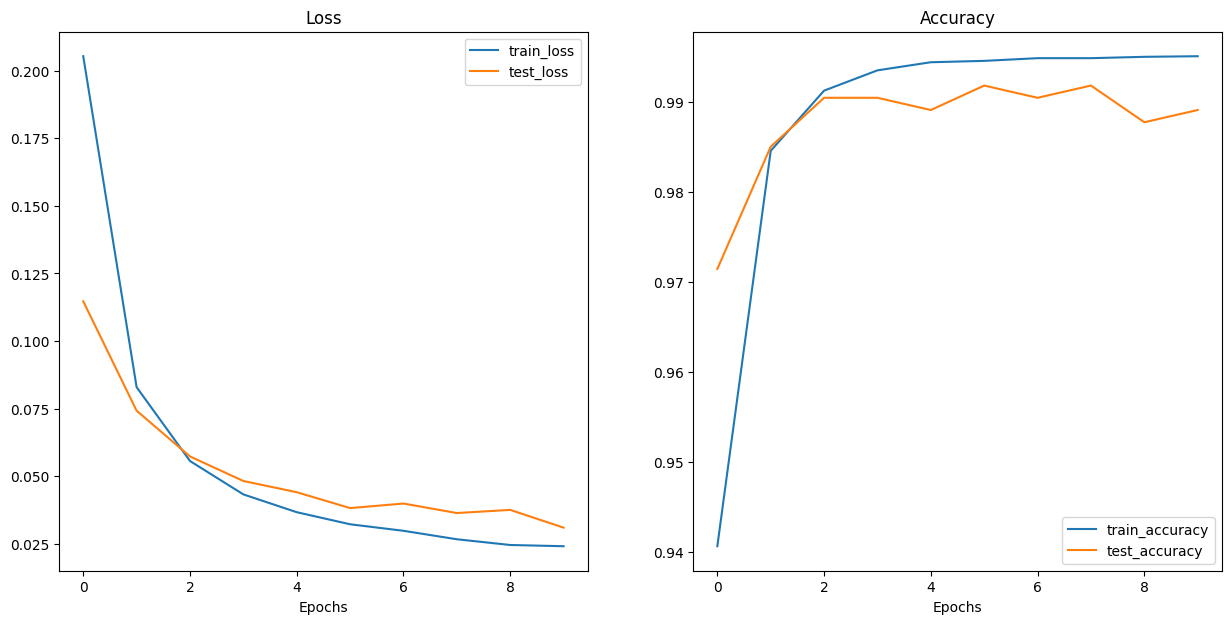

In [32]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

# Prediction:

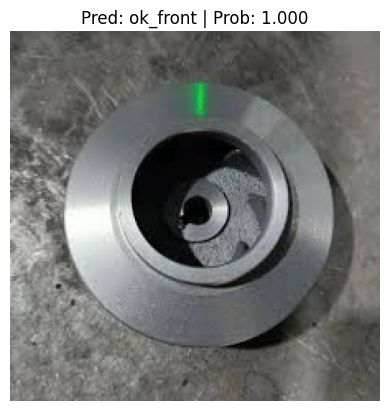

In [39]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "2.jpeg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

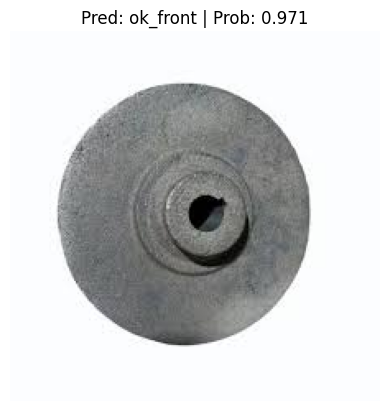

In [41]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "1.jpeg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)